# PhatStack #

Financial projections often consider several different scenarios, all playing out uniquely over time. Those scenarios are often weighted by likelihood when attempting to coalesce them into an estimate of, say, an asset's value.

Share price movements are particularly difficult in this respect. An analyst might model several potential scenarios for the underlying performance of the target company going forward, but has only the historic price movements of the shares to consider. And those price movements may have no relation to the likelihood price movements one could expect under the projected scenarios.

One approach is to seek out historical price movements in other companies, whose financial performance at the time closely reflected the scenarios considered for the target company. One (or several) representative distribution(s) could be used to project share price movements, with the number of projections for each distribution a function of the weighted likelihood of each scenario.

`phat-tails` can produce such a projection using the `PhatStack` class, which is a mixture-type combination of multiple `Phat` distributions.

In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns; sns.set(style = 'whitegrid')

## AR-GARCH ##

To demonstrate the approach, we will project the go-forward share price movements ot Peloton Interactive, Inc. ([PTON](https://finance.yahoo.com/quote/PTON?p=PTON)) based on the historical price performance of three other companies: [NFLX](https://finance.yahoo.com/quote/NFLX?p=NFLX), [GRPN](https://finance.yahoo.com/quote/GRPN?p=GRPN), and [YELP](https://finance.yahoo.com/quote/YELP?p=YELP).

Process is as follows. For each of the 3 companies:

1. obtain daily return data 
2. fit AR(2)-GARCH(1,1)
3. fit Phat distribution to AR-GARCH residuals

Then,

1. pass the resulting Phat distributions to a `PhatStack` instance
2. pass the AR-GARCH results and the `PhatStack` instance to `GarchCaster`

In [2]:
import datetime as dt
import arch
import matplotlib.pyplot as plt

import yfinance as yf
from tqdm.auto import tqdm

import phat as ph

First, we download the historical price performance and convert to returns. We can see the dramatic difference in performance between the three over the past 12 years.

In [3]:
stocks = yf.download('NFLX GRPN YELP')
rets = stocks.Close.pct_change().dropna()*100

[*********************100%***********************]  3 of 3 completed


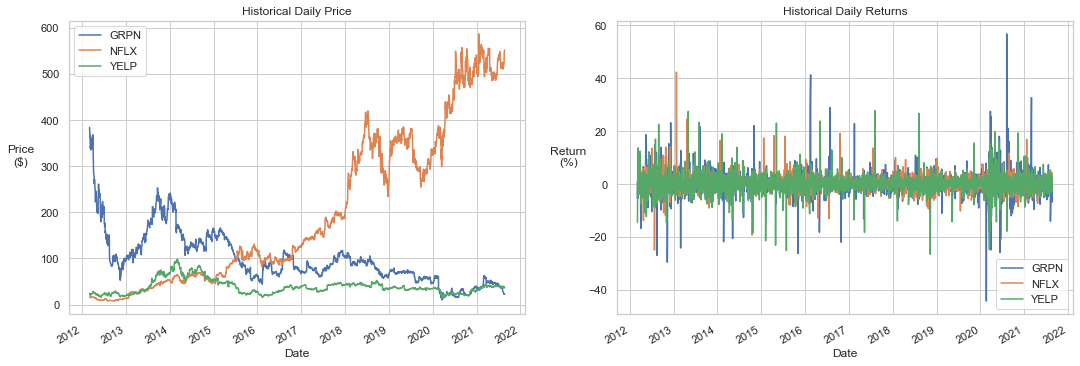

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 6))
stocks.loc['2012-03-02':].Close.plot(ax=ax1)
rets.loc['2012-03-02':].plot(ax=ax2)

ax1.set_title('Historical Daily Price')
ax1.set_ylabel('Price\n($)', rotation='horizontal', labelpad=20)

ax2.set_title('Historical Daily Returns')
ax2.set_ylabel('Return\n(%)', rotation='horizontal', labelpad=20)

plt.show()

Then we fit an AR(2)-GARCH(1,1) model to each time series.

In [5]:
import os
import pickle
import pandas as pd
TEST_ROOT = '/Users/spindicate/Documents/programming/investing/analysis/options/phat/tests/'

In [17]:
YELP = pd.read_csv(f'{TEST_ROOT}yelp_returns.csv', index_col='Date')

In [18]:
from arch.univariate import ConstantMean

# ar = ConstantMean(YELP)
# ar.volatility = arch.univariate.GARCH(p=1, q=1)
# res_for_sym = ar.fit(update_freq=0, disp="off")

ar = arch.univariate.ARX(YELP, lags=[1, 2])
ar.volatility = arch.univariate.GARCH(p=1, q=1)
res_for_sym = ar.fit(update_freq=0, disp="off")

# res.append(res_for_sym)
# res.append(res_for_sym)

In [60]:
res_for_sym

                           AR - GARCH Model Results                           
Dep. Variable:                   YELP   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -6405.27
Distribution:                  Normal   AIC:                           12822.5
Method:            Maximum Likelihood   BIC:                           12857.2
                                        No. Observations:                 2380
Date:                Mon, Aug 23 2021   Df Residuals:                     2377
Time:                        19:14:48   Df Model:                            3
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.1541      0.100      1.539      0.124 

In [20]:
with open(f'{TEST_ROOT}argarch211.pickle', 'wb') as file:
    pickle.dump(phat, file)
    
with open(f'{TEST_ROOT}argarch211.pickle', 'rb') as file:
    phat = pickle.load(file)

In [33]:
xil, xir = ph.two_tailed_hill_double_bootstrap(res_for_sym.std_resid[2:])
data = ph.DataSplit(res_for_sym.std_resid[2:]/10)

pnet = ph.PhatNet(neurons=1)
pnet.compile(
    loss = ph.PhatLoss(xil,xir),
    optimizer = 'adam',
    metrics=[ph.PhatMetric('shape_left'), ph.PhatMetric('shape_right')]
)
history = pnet.fit(data.train, validation_data=data.test, epochs=100, verbose=0)
    
mu, sig, l, r = pnet.predicted_params().values
phat = ph.Phat(mu*10, sig*10, l, r)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 00056: early stopping


In [34]:
with open(f'{TEST_ROOT}argarch211_phat.pickle', 'wb') as file:
    pickle.dump(phat, file)
    
with open(f'{TEST_ROOT}argarch211_phat.pickle', 'rb') as file:
    phat = pickle.load(file)

In [78]:
gcast = ph.Garchcaster(
    res_for_sym,
    iters=1052,
    periods=90,
    dist=phat,
)

In [79]:
with open(f'{TEST_ROOT}argarch211_gcast.pickle', 'wb') as file:
    pickle.dump(gcast, file)
    
with open(f'{TEST_ROOT}argarch211_gcast.pickle', 'rb') as file:
    gcast = pickle.load(file)

PicklingError: Can't pickle <class 'phat.tseries.Garchcaster'>: it's not the same object as phat.tseries.Garchcaster

In [77]:
gcast.dist

AttributeError: 'Phat' object has no attribute 'dist'

In [39]:
gres = gcast.forecast(seed=1342)

In [63]:
gcast.vol.q

1

In [59]:
gcast.mean.constant

0.15405467876723755

In [57]:
gcast.vol.constant

-0.04711447665300084

In [38]:
with open(f'{TEST_ROOT}argarch211_gres.pickle', 'wb') as file:
    pickle.dump(phat, file)
    
with open(f'{TEST_ROOT}argarch211_gres.pickle', 'rb') as file:
    phat = pickle.load(file)

In [11]:
# fore = gcast.forecast(seed=1100)

# with open(f'{TEST_ROOT}cmean_foreres.pickle', 'wb') as file:
#     pickle.dump(fore, file)

with open(f'{TEST_ROOT}cmean_foreres.pickle', 'rb') as file:
    fore = pickle.load(file)

In [12]:
fore

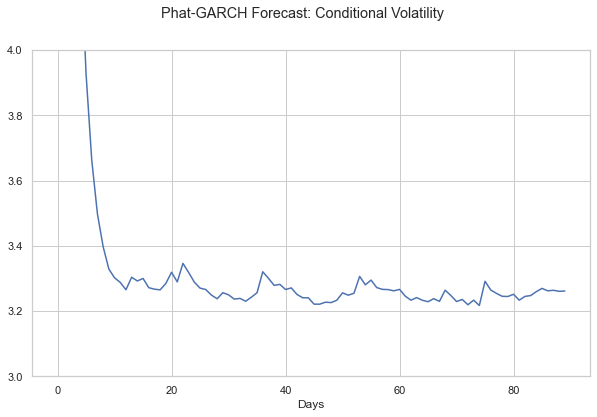

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
fore.plot(ax=ax)
ax.set_ylim(3,4)
plt.show()

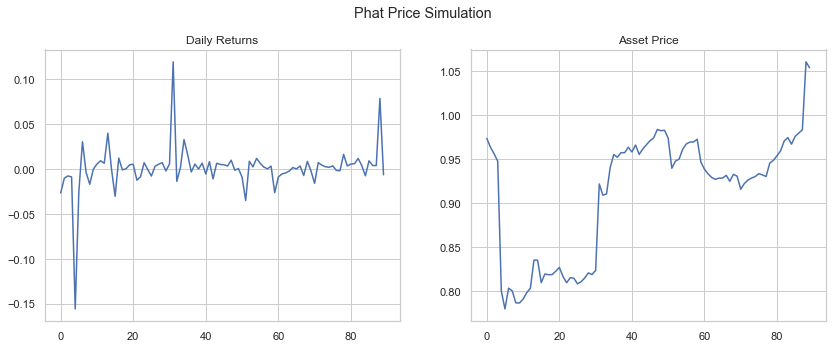

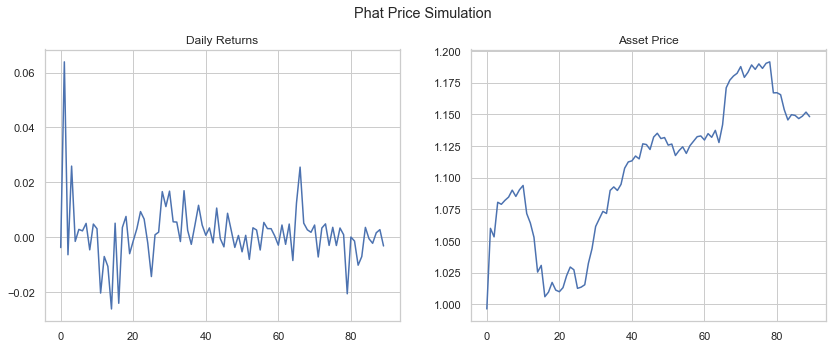

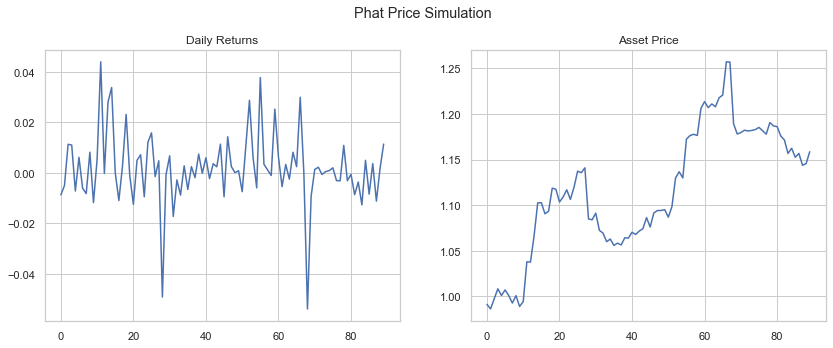

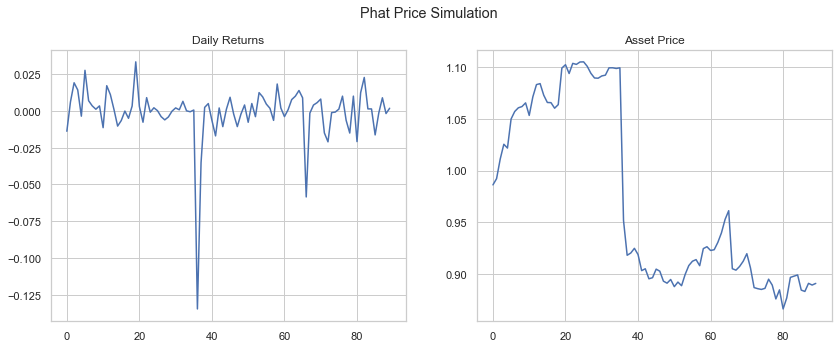

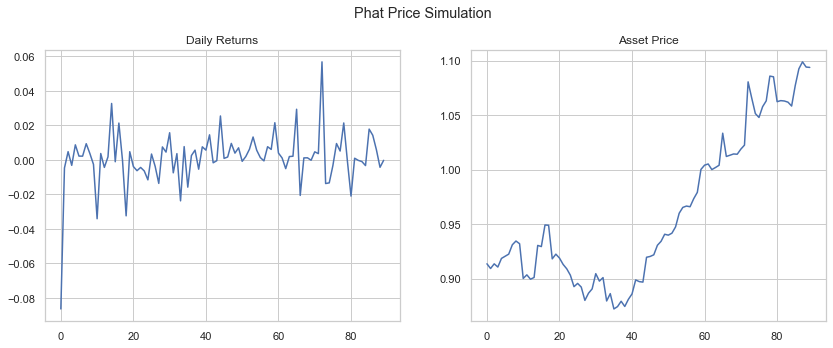

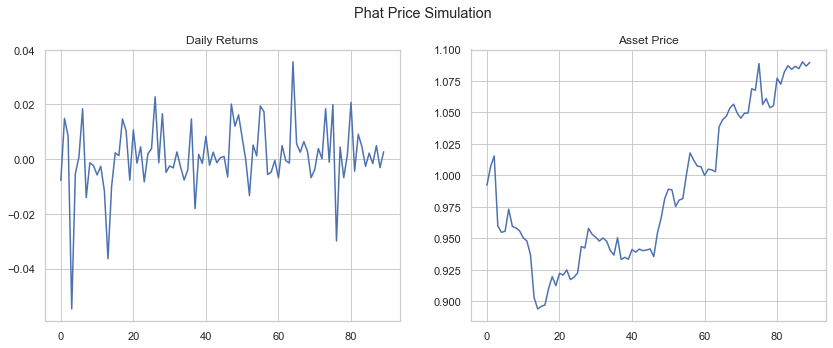

In [14]:
fore.plot('price', p=1, n=6)
plt.show()

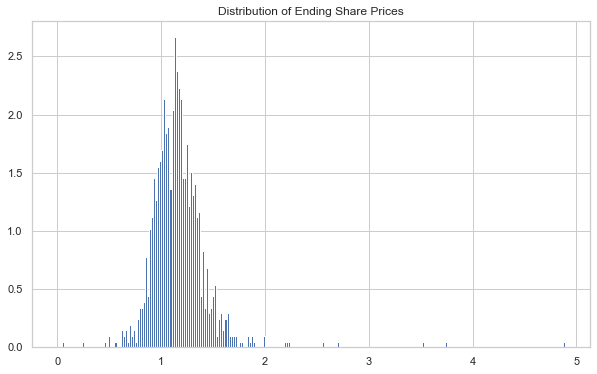

In [15]:
fore.plot('end_price', p=1)
plt.show()

In [353]:
res = []
for sym, ret in rets.iteritems():
    ar = arch.univariate.ARX(ret, lags=[1,2])
    ar.volatility = arch.univariate.GARCH(p=1, q=1)
    res_for_sym = ar.fit(update_freq=0, disp="off")
    res.append(res_for_sym)

Then we fit a Phat distribution to the AR-GARCH residuals.

In [357]:
pbar = dict(leave=False)
phats = []
for result in tqdm(res, total=(len(res))):
    xil, xir = ph.two_tailed_hill_double_bootstrap(result.std_resid[2:], pbar_kwargs=pbar)
    data = ph.DataSplit(result.std_resid[2:]/10)

    pnet = ph.PhatNet(neurons=1)
    pnet.compile(
        loss = ph.PhatLoss(xil,xir),
        optimizer = 'adam',
        metrics=[ph.PhatMetric('shape_left'), ph.PhatMetric('shape_right')]
    )
    history = pnet.fit(data.train, validation_data=data.test, epochs=100, verbose=0)
    
    mu, sig, l, r = pnet.predicted_params().values
    phat = ph.Phat(mu*10, sig*10, l, r)
    phats.append(phat)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 00061: early stopping


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 00022: early stopping


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 00029: early stopping


Then, we create an `PhatStack` instance from the components. The three component distributions are weighted such that the YELP configuration is most common, then NFLX, then GRPN.

In [359]:
p = np.array([.3, .2, .5])
pstack = PhatStack(*phats, p=p)

In [ ]:
arch.

In [371]:
res[0]

                           AR - GARCH Model Results                           
Dep. Variable:                   GRPN   R-squared:                      -0.000
Mean Model:                        AR   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6756.94
Distribution:                  Normal   AIC:                           13525.9
Method:            Maximum Likelihood   BIC:                           13560.5
                                        No. Observations:                 2379
Date:                Wed, Aug 18 2021   Df Residuals:                     2376
Time:                        13:01:12   Df Model:                            3
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const         -0.0874  9.164e-02     -0.953      0.340 

In [382]:
res[0].model

AR(constant: yes, lags: 1, 2, no. of exog: 0, volatility: GARCH(p: 1, q: 1), distribution: Normal distribution), id: 0x23ae232b0

In [17]:
n = 10000
days = 252*2
for stock in tqdm(stocks, total=len(stocks)):    
    fit_params = stock.fit.params.copy()


  0%|          | 0/11 [00:00<?, ?it/s]

In [423]:
fit_params = stocks[5].fit.params.copy()

In [426]:
fit_params

Const       0.003968
PTON[1]    -0.017765
PTON[2]    -0.027630
omega       1.308399
alpha[1]    0.017358
beta[1]     0.916986
Name: params, dtype: float64

In [439]:
fit_params.Const = 140 / (252*2)

In [440]:
stocks[5].forecast = ph.Garchcaster(
    stocks[5].fit.std_resid.values[2:].copy(),
    stocks[5].fit.conditional_volatility.values[2:].copy(),
    stocks[5].fit.resid.values[2:].copy(),
    fit_params[:3].values,
    fit_params[[0,3,4,5]].values,
    iters=n,
    periods=days,
    order=(2,0,1,1),
).forecast(dist=stocks[5].phat)

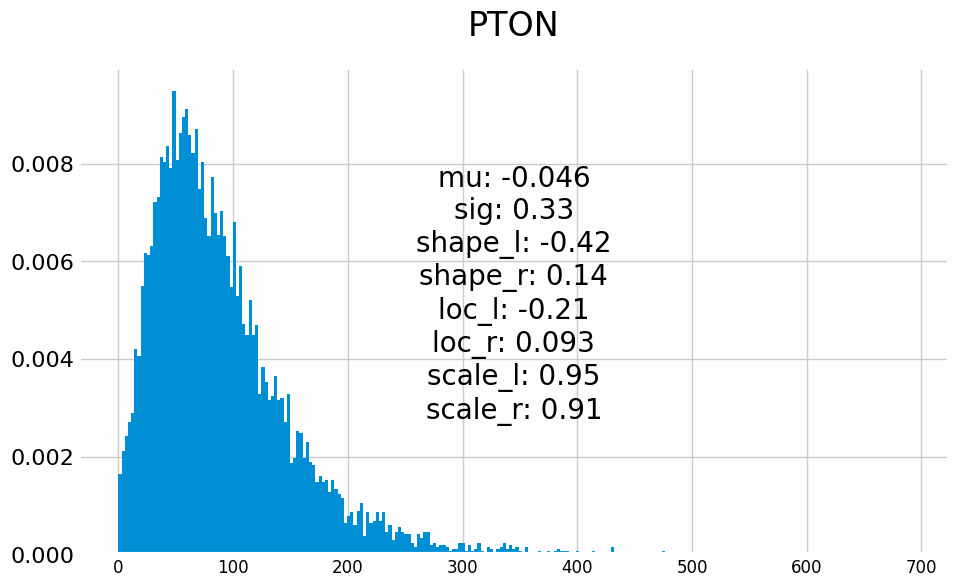

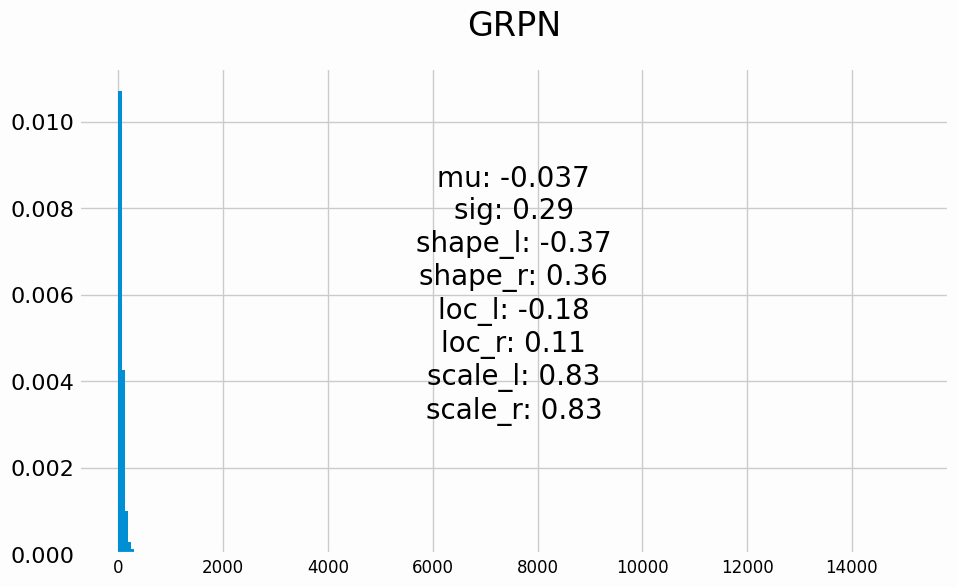

In [504]:
ps = np.zeros((2, n, days))
for i, stock in enumerate(stocks[[5,6]]):
    ax, P, bins = stock.forecast.plot('end_price', p=stocks[0].price)
    ps[i] = P
    txt = ''
    for label, param in stock.phat.params.items():
        txt += f'{label}: {param[0]:.2}'
        txt += '\n'
    ax.text(.5,.5, txt, transform=ax.transAxes, ha='center', va='center')
    plt.title(f'{stock.symbol}')
    plt.show()

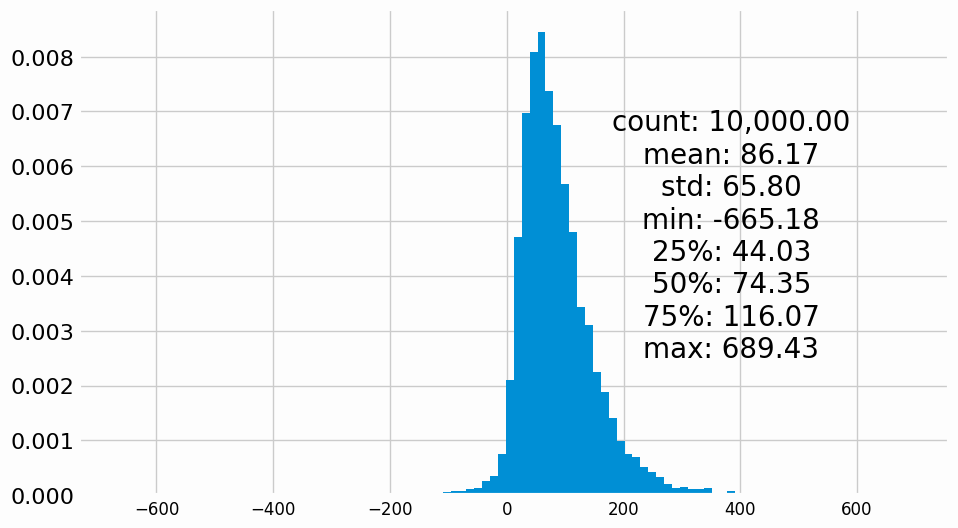

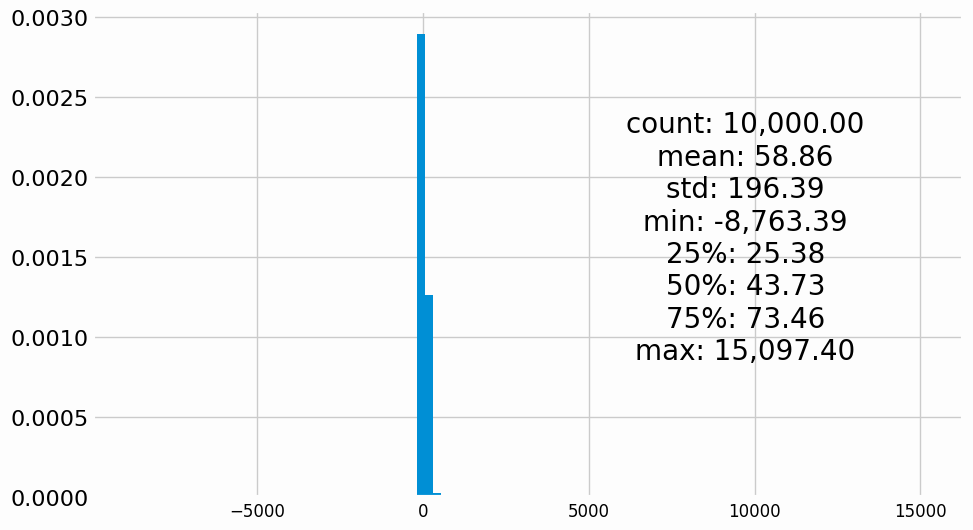

In [505]:
for p in ps:
    deschist(p[:, -1])
    plt.show()

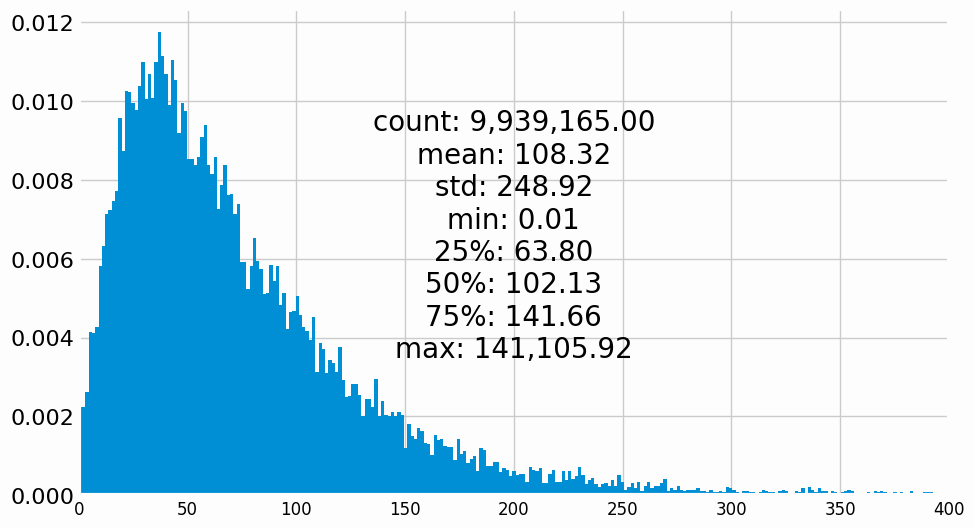

In [506]:
fig, ax = plt.subplots(figsize=(10,6))

counts, bins, _ = ax.hist(ps[:, :, -1][ps[:, :, -1]>0], bins=10000, stacked=True, density=True)
desc = pd.Series(ps[ps>0]).describe()

txt = ''
for label, param in desc.iteritems():
    txt += f'{label}: {param:,.2f}'
    txt += '\n'

ax.text(.5,.5, txt, transform=ax.transAxes, ha='center', va='center')

ax.set_xlim(0,400)
plt.show()

## Theta Strangle ##

In [507]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [508]:
def deschist(vals, ax=None, txt_kwargs=dict(x=.75, y=.5, ha='center', va='center')):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,6))

    ax.hist(vals, bins=100, density=True)
    desc = pd.Series(vals).describe()

    txt = ''
    for label, param in desc.iteritems():
        txt += f'{label}: {param:,.2f}'
        txt += '\n'
    txt_kwargs['s'] = txt
    txt_kwargs['transform'] = ax.transAxes
    ax.text(**txt_kwargs)
    
    return ax

In [509]:
import operator as op

In [737]:
import operator as op
from typing import Iterable, Union
from analysis.options.strategies import CompoundStrategy, TStrangle

def per_profitable(ser):
    return (ser > 0).sum() / ser.shape[0]

def expected_value(ser):
    counts, bins = np.histogram(ser.values, bins=100, density=True)
    probs = counts / counts.sum()
    mids = (bins[:-1] + bins[1:]) / 2
    return (mids*probs).sum()

def q25(ser):
    return ser.quantile(.25)

def q75(ser):
    return ser.quantile(.75)

class Strategies(np.ndarray):
    def __new__(cls, strats:Iterable, name:str=''):
        obj = np.asarray(strats).view(cls)

        obj.name = name
        for strat in obj:
            setattr(cls, strat.name, strat)

        return obj

    def __array_finalize__(self, obj):
        if obj is None: return        

    @property
    def nets(self):
        return self._nets
    
    @property
    def ser(self):
        return self._ser
    
    @property
    def stats(self):
        return self._stats
    
    def _get_nets(self, p):
        nets = {}
        ser = {}
        for strat in self:
            net = strat.net(s=p)
            nets[strat.name] = net
            ser[strat.name] = strat
        
        nets = pd.DataFrame(nets).T
        nets.index.names = [f'{self.name} K']

        if isinstance(self[0], CompoundStrategy):
            nets.index = pd.MultiIndex.from_arrays(
                np.array(pd.Series([
                    i[1] for i in nets.index.str.split(' ')]).str.split('-').tolist()).astype('float').T,
                names=['Put K', 'Call K']
            )    
            
        ser = pd.Series(ser)
        self._nets = nets
        self._ser = ser
        
        return nets, ser
        
    def _get_stats(self):
        stats = self.nets.apply(pd.Series.describe, axis=1)
        stats['median'] = self.nets.apply(pd.Series.median, axis=1)
        stats['per_prof'] = self.nets.apply(per_profitable, axis=1)
        stats['exp_value'] = self.nets.apply(expected_value, axis=1)
        stats['outlay'] = np.array([s.outlay() for s in self.ser])
        
        stats['exp_ret'] = stats.exp_value / stats.outlay
        stats['strat_obj'] = self.ser.values
        
        self._stats = stats
        return stats    
    
    def sim(self, p):
        _, __ = self._get_nets(p)
        stats = self._get_stats()
        return stats

    def heatmap(self,
        category,
        x='Call K', y='Put K', 
        filt=(),
        ax=None, 
        xlabel_kws=dict(xlabel='Call K', size=15),
        ylabel_kws=dict(ylabel='Put K', size=15, loc='top', rotation='horizontal'),
        title_kws={}
        ):
        if ax is None:
            fig, ax = plt.subplots(1,1,figsize=(10,6))

        stats = self.stats[getattr(op, filt[0])(self.stats[category], filt[1])] if filt else self.stats
        pivot_table = stats.pivot_table(
            values=category, 
            index=[y], 
            columns=x, 
            aggfunc=np.mean
        )
        sns.heatmap(pivot_table, ax=ax, cbar=True, annot=False, linewidths=.5, cmap = 'crest')

        ax.set_xlabel(**xlabel_kws)
        ax.set_ylabel(**ylabel_kws)

        titles = {
            'exp_value': 'Expected Value',
            'per_prof': 'Percentage Profitable',
            'exp_ret': 'Expected Return',
            '75%': '75 Quantile',
            '25%': '25 Quantile',            
        }
        ax.set_title(label=titles[category], **title_kws)

        return ax

In [746]:
import datetime as dt

In [747]:
dt.date

datetime.date

In [748]:
n_call = (pd.Timestamp(pton.calls['expiry'].unique()[-5]) - pd.Timestamp(dt.date.today())).days
end_call = ps[:, :, n_call]
end_call = end_call[end_call>0]
end_call = np.sort(end_call)[50:-50]

n_put = (pd.Timestamp(pton.puts['expiry'].unique()[-2]) - pd.Timestamp(dt.date.today())).days
end_put = ps[:, :, n_put]
end_put = end_put[end_put>0]
end_put = np.sort(end_put)[500:-500]

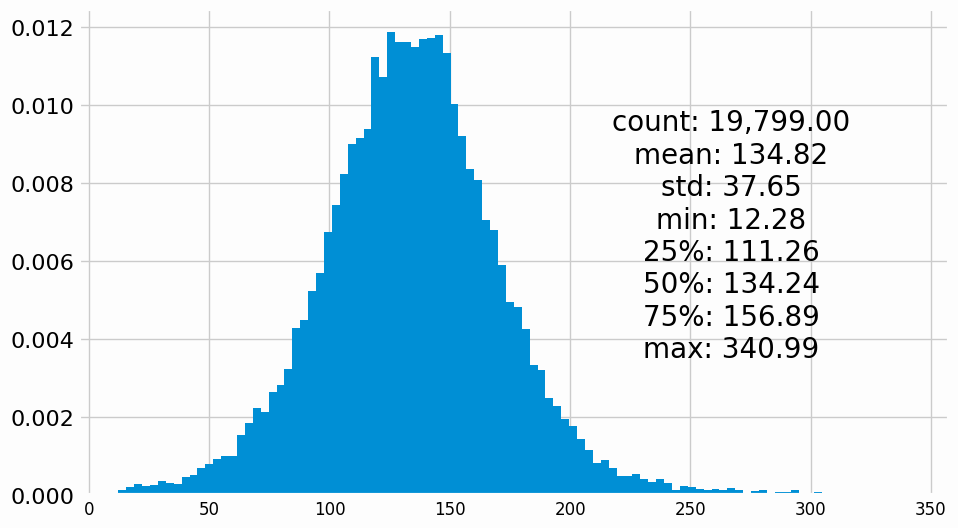

In [749]:
deschist(end_call)
plt.show()